In [1]:
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn import model_selection, preprocessing
from keras.utils import np_utils
import pickle
import pandas
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from keras.models import Sequential
from keras.layers.core import Dense, Activation
import matplotlib
import matplotlib.pyplot as plt
from keras.layers import LSTM, RNN, SimpleRNN, Dropout
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


/Users/alleriali/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/alleriali/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
nltk.download('punkt') ##this downloads the default word tokenizer
nltk.download('stopwords') ##this downloads all stopwords
nltk.download('popular') ##this downloads many different popular libraries 

[nltk_data] Downloading package punkt to /Users/alleriali/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alleriali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/alleriali/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/alleriali/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/alleriali/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/alleriali/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading pa

True

In [3]:
get_data = open("/Users/alleriali/PycharmProjects/pdf_reader/venv/data.pickle","rb")
data = pickle.load(get_data)

for label in data.keys():
    print(label,len(data[label]))
    print(data[label])
    




rechnung 41
['Digitec Galaxus AG\nPfingstweidstrasse 60b\nCH-8005 Zürich\n\nT +41 44 575 95 00\nF +41 44 575 95 01\ndigitec@digitec.ch\n\nwww.digitec.ch\n\nRechnung 6277821\nRechnungsdatum\nFälligkeitsdatum\nAuftrag\nKundennummer\nIhre Referenz Person\nMwSt. Nr.\nLieferoption\nZahlungsbedingungen\nWährung\n\n06.08.2018\n26.08.2018\n15533987\n1202047\nMarc Bravin\nCHE-109.049.266 MWST\nVersand\n20 Tage netto\nCHF\n\nMarc Bravin\nRisismühle 2\nCH-6370 Stans\nSchweiz\n\nBeschreibung\n\nArtikel-Nummer Lieferung\n\nMenge\n\nHonor 10 (5.84", 64GB, Dual SIM, 16MP, Magic Night Black)\nIMEI: 868288037752427\n\nRechnung Gebühren\n\n8586327\n\n06.08.2018\n\n06.08.2018\n\n1\n\n1\n\nPreis\n\n409.00\n379.76\n\nMwSt.\n\ninkl. 7.7%\nexkl. 7.7%\n\n9.26\n8.60\n\ninkl. 7.7%\nexkl. 7.7%\n\nBetrag\n\n409.00\n379.76\n\n9.26\n8.60\n\nGesamtbetrag\n\nCHF inkl.\n\nCHF exkl.\n\n418.26\n\n388.36\n\nSteuersatz Betrag exkl.\n388.36\n\n7.7%\n\nBetrag inkl.\n418.26\n\nAllgemein\nGarantieleistungen\n\nEs gelten unser

In [4]:
def stem_list(tokens_list):
    stemmer = SnowballStemmer('german')
    return [stemmer.stem(token) for token in tokens_list]


# remove stopwords
def remove_stopwords(tokens_list):
    return [token for token in tokens_list
            if token not in stopwords.words(u'german')]


# relapce numeric by constant string 'NUM'
def replace_numeric(tokens_list):
    result = []
    for token in tokens_list:
        if token == '2018' or token == '2017' or token == '2016':
            result.append('YEAR')
        elif token.isnumeric():
            result.append('NUM')
        else:
            result.append(token)
    return result


# remove all tokens that contains non alpha numeric, punctuation, or less than 3 length
# def remove_containing_non_alphanum(tokens_list):
#     return [token for token in tokens_list if len(token) >= 3 and (token.isalpha() or token.isnumeric())]


def highlight_first_five_tokens(original_tokens):
    tokens = []
    for i in range(len(original_tokens)):
        tokens.append(original_tokens[i])
        if i < 5:
            tokens.append("erstfuf" + original_tokens[i])
    return tokens

def TokenizeDoc(doc):
    tokenized = nltk.word_tokenize(doc, language='german')
    lowercased = [word.lower() for word in tokenized]
    stemmed = remove_stopwords(stem_list(lowercased))
    final = highlight_first_five_tokens(replace_numeric(stemmed))

    return final

def CleanDoc(doc):
    return ' '.join(TokenizeDoc(doc))

In [5]:
word_tset = 'Digitec Galaxus AG\nPfingstweidstrasse 60b\nCH-8005 Zürich\n\nT +41 44 575 95 00\nF +41 44 575 95 01\ndigitec@digitec.ch\n\nwww.digitec.ch\n\nRechnung 6277821'
toke_tests = CleanDoc(word_tset)
print(toke_tests)


digitec erstfufdigitec galaxus erstfufgalaxus ag erstfufag pfingstweidstrass erstfufpfingstweidstrass 60b erstfuf60b ch-8005 zurich t +41 NUM NUM NUM NUM f +41 NUM NUM NUM NUM digitec @ digitec.ch www.digitec.ch rechnung NUM


In [6]:
import pandas as pd
from sklearn import model_selection, preprocessing
from collections import defaultdict

label2int = defaultdict()
label2int.default_factory = label2int.__len__

labels, docs, label_name = [], [], []
for label, pdfs in data.items():
    print(label, label2int[label])
    label_name.append(label)
    for pdf in pdfs:
        if pdf == '':
            continue
        labels.append(label2int[label])
        docs.append(pdf)

# create a dataframe using texts and lables
trainDF = pd.DataFrame()
trainDF['original_doc'] = docs
trainDF['label'] = labels
trainDF['doc'] = trainDF.apply(lambda row: 
                               CleanDoc(row['original_doc']), axis=1)
trainDF = trainDF[lambda row: row['doc'] != '']
train_x, test_x, train_y, test_y = model_selection.train_test_split(trainDF['doc'], trainDF['label'],test_size=0.2)


rechnung 0
Vertrag 1
statuten 2
Zertifikaten 3


In [7]:
len_doc = [len(x) for x in train_x]
print(max(len_doc))
print(len_doc)


154730
[2117, 6323, 2709, 2725, 2822, 20325, 1184, 16422, 2578, 3376, 1527, 1828, 1222, 535, 1505, 822, 1891, 1729, 1091, 1400, 1558, 1944, 862, 2736, 1016, 2770, 1232, 3281, 1575, 965, 2086, 1968, 3189, 989, 6524, 5118, 8563, 2642, 1212, 1982, 3558, 723, 750, 1138, 1432, 2798, 2298, 1524, 27770, 1624, 1424, 516, 3173, 2242, 1076, 1128, 1012, 1846, 7606, 2512, 3155, 154730, 975, 3059, 3002, 3226, 973, 1411, 2203, 3655, 1073, 923, 2836, 4512, 1555, 1807, 567, 1972, 1426, 7453, 6886, 2578, 4062, 2773, 1921, 2353, 1361, 1478, 1601, 1130, 562, 5038, 2647, 1457, 940, 10192, 3582, 1814, 2180, 759, 1116, 1982, 990, 2138, 7102, 6962, 1937, 4095, 1586, 2810, 1419, 7097]


In [8]:
# Count vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

count_vectorizer = CountVectorizer(ngram_range=(1,1))
tf_docs = count_vectorizer.fit_transform(train_x) # sparse matrix

tf_docs_dataframe = pd.DataFrame(tf_docs.toarray(),columns=count_vectorizer.get_feature_names())
tf_docs_dataframe.head()

,00,000,0000,000000000000000000106825853,000000000010200182705204906,000000130573900000166349620,0001,000861519233004380380720160,000861519233009754350920167,000861519233010010780120179,...,zwischenmensch,zwischensumm,zwischentotal,zwischenzeit,zwischenzeugnis,zwolf,zwolftel,zzgl,zzuumm,µm
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Tfidf Vectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))
tfidf_docs = tfidf_vectorizer.fit_transform(train_x)

df_docs_dataframe = pd.DataFrame(tfidf_docs.toarray(), columns = tfidf_vectorizer.get_feature_names())
df_docs_dataframe.head()

,00,000,0000,000000000000000000106825853,000000000010200182705204906,000000130573900000166349620,0001,000861519233004380380720160,000861519233009754350920167,000861519233010010780120179,...,zwischenmensch,zwischensumm,zwischentotal,zwischenzeit,zwischenzeugnis,zwolf,zwolftel,zzgl,zzuumm,µm
0,0.116493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.033982,0.0,0.0,0.0
2,0.126793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [10]:
# Naive Bayes: count vectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import numpy as np
from sklearn import metrics
mnb = MultinomialNB()
mnb.fit(tf_docs, train_y)

tf_docs_test = count_vectorizer.transform(test_x)
pre_mnb = mnb.predict(tf_docs_test)
cm_mnb = metrics.confusion_matrix(test_y,pre_mnb)
ac_mnb = accuracy_score(pre_mnb, test_y)
print(cm_mnb)
f1_mnb = f1_score(mnb.predict(tf_docs_test), test_y, average=None)
print(ac_mnb, f1_mnb)
#cm_metrics.confusion_matrix

feature_names = np.array(count_vectorizer.get_feature_names())
feature_importances = np.argsort(mnb.coef_[0])[-20:]
for idx in feature_importances:
    print(feature_names[idx])

[[ 8  0  0  0]
 [ 1  5  0  0]
 [ 0  0 12  0]
 [ 0  1  0  1]]
0.9285714285714286 [0.94117647 0.83333333 1.         0.66666667]
fur
70
08
marc
09
swisscom
bravin
schweiz
www
ag
01
2017
betrag
rechnung
10
chf
mwst
ch
00
num


In [11]:
# Naive Bayes: count vectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

bnb = BernoulliNB()
bnb.fit(tf_docs, train_y)

tf_docs_test = count_vectorizer.transform(test_x)
pre_bnb = bnb.predict(tf_docs_test)
ac_bnb = accuracy_score(pre_bnb, test_y)
f1_bnb = f1_score(bnb.predict(tf_docs_test), test_y, average=None)
cm_bnb = metrics.confusion_matrix(test_y,pre_bnb)
print(ac_bnb, f1_bnb)
feature_names = np.array(count_vectorizer.get_feature_names())
feature_importances = np.argsort(bnb.coef_[0])[-10:]
for idx in feature_importances:
    print(feature_names[idx])

0.8214285714285714 [0.84210526 0.8        0.88       0.        ]
fur
01
che
ch
chf
www
mwst
rechnung
00
num


/Users/alleriali/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


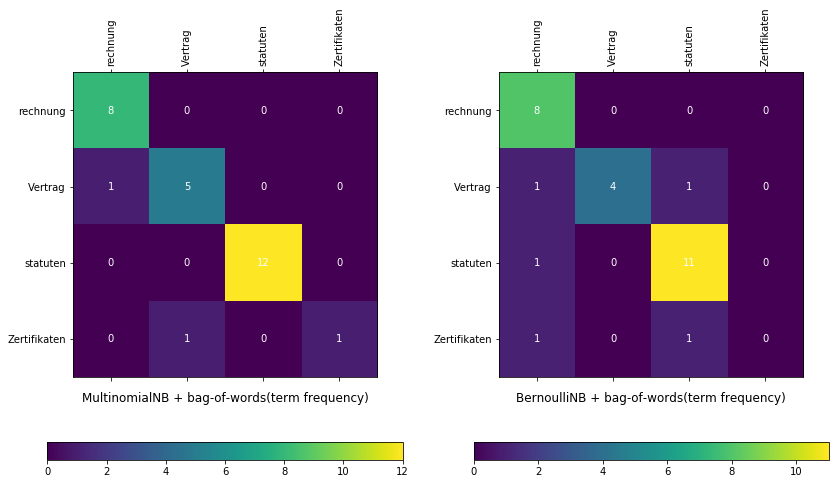

In [12]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(121)
cax = ax.matshow(cm_mnb)

for i in range(cm_mnb.shape[0]):
    for j in range(cm_mnb.shape[1]):
        text = ax.text(j, i, cm_mnb[i, j],
                       ha="center", va="center", color="w")
        
#p0 = ax.get_position().get_points().flatten()
plt.colorbar(cax,orientation='horizontal')

# Set up axes
ax.set_xticklabels([''] + label_name, rotation=90)
ax.set_yticklabels([''] + label_name)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_title("MultinomialNB + bag-of-words(term frequency)",y=-0.1)
# sphinx_gallery_thumbnail_number = 2
ax1 = fig.add_subplot(122)
cax1 = ax1.matshow(cm_bnb)
for i in range(cm_bnb.shape[0]):
    for j in range(cm_bnb.shape[1]):
        text = ax1.text(j, i, cm_bnb[i, j],
                        ha="center", va="center", color="w")
        
plt.colorbar(cax1,orientation='horizontal')

# Set up axes
ax1.set_xticklabels([''] + label_name, rotation=90)
ax1.set_yticklabels([''] + label_name)

# Force label at every tick
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set_title("BernoulliNB + bag-of-words(term frequency)",y=-0.1)
# sphinx_gallery_thumbnail_number = 2
#plt.tight_layout()
plt.show()

[[ 8  0  0  0]
 [ 1  5  0  0]
 [ 0  0 12  0]
 [ 0  1  0  1]]


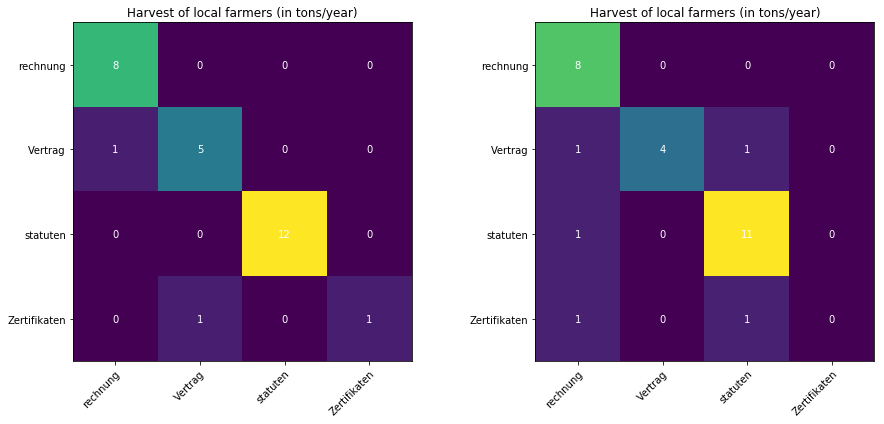

In [13]:
fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize = (13,6))
print(cm_mnb)
im1 = ax1.imshow(cm_mnb)
ax2.imshow(cm_bnb)

# We want to show all ticks...
ax1.set_xticks(np.arange(len(label_name)))
ax1.set_yticks(np.arange(len(label_name)))
# ... and label them with the respective list entries
ax1.set_xticklabels(label_name)
ax1.set_yticklabels(label_name)

# Rotate the tick labels and set their alignment.
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(label_name)):
    for j in range(len(label_name)):
        text1 = ax1.text(j, i, cm_mnb[i, j],
                       ha="center", va="center", color="w")

ax2.set_title("Harvest of local farmers (in tons/year)")

# We want to show all ticks...
ax2.set_xticks(np.arange(len(label_name)))
ax2.set_yticks(np.arange(len(label_name)))
# ... and label them with the respective list entries
ax2.set_xticklabels(label_name)
ax2.set_yticklabels(label_name)

# Rotate the tick labels and set their alignment.
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(label_name)):
    for j in range(len(label_name)):
        text2 = ax2.text(j, i, cm_bnb[i, j],
                       ha="center", va="center", color="w")

ax1.set_title("Harvest of local farmers (in tons/year)")

fig.tight_layout()
plt.show()

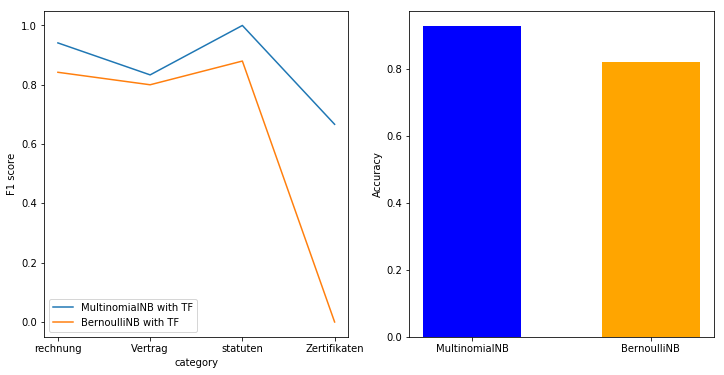

In [14]:
from matplotlib.pyplot import subplots, show

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(label_name,f1_mnb,label='MultinomialNB with TF')
plt.plot(label_name,f1_bnb,label='BernoulliNB with TF')
plt.legend()
plt.xlabel("category")
plt.ylabel("F1 score")
plt.subplot(1,2,2)
plt.bar(["MultinomialNB","BernoulliNB"],[ac_mnb,ac_bnb],color=['blue','orange'],width = 0.55)
plt.ylabel("Accuracy")
show()

In [15]:
# Naive Bayes: tfidf vectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

mnb = MultinomialNB()
mnb.fit(tfidf_docs, train_y)

tfidf_docs_test = tfidf_vectorizer.transform(test_x)
pre_mnb_idf = mnb.predict(tfidf_docs_test)
ac_mnb_idf = accuracy_score(pre_mnb_idf, test_y)
f1_mnb_idf = f1_score(pre_mnb_idf, test_y, average=None)
cm_mnb_idf = metrics.confusion_matrix(test_y,pre_mnb_idf)
print(cm_mnb_idf)
print(ac_mnb_idf, f1_mnb_idf)
feature_names = np.array(tfidf_vectorizer.get_feature_names())
feature_importances = np.argsort(mnb.coef_[0])[-10:]
for idx in feature_importances:
    print(feature_names[idx])

[[ 8  0  0  0]
 [ 1  5  0  0]
 [ 1  0 11  0]
 [ 2  0  0  0]]
0.8571428571428571 [0.8        0.90909091 0.95652174 0.        ]
swisscom
betrag
10
rechnung
2017
chf
ch
mwst
00
num


/Users/alleriali/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [16]:
# Naive Bayes: tfidf vectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

bnb = BernoulliNB()
bnb.fit(tfidf_docs, train_y)

tfidf_docs_test = tfidf_vectorizer.transform(test_x)
pre_bnb_idf = bnb.predict(tfidf_docs_test)
ac_bnb_idf = accuracy_score(pre_bnb_idf, test_y)
f1_bnb_idf = f1_score(pre_bnb_idf, test_y, average=None)
cm_bnb_idf = metrics.confusion_matrix(test_y,pre_bnb_idf)
print(ac_bnb_idf, f1_bnb_idf)
print(cm_bnb_idf)
feature_names = np.array(tfidf_vectorizer.get_feature_names())
feature_importances = np.argsort(bnb.coef_[0])[-10:]
for idx in feature_importances:
    print(feature_names[idx])

0.8214285714285714 [0.84210526 0.8        0.88       0.        ]
[[ 8  0  0  0]
 [ 1  4  1  0]
 [ 1  0 11  0]
 [ 1  0  1  0]]
fur
01
che
ch
chf
www
mwst
rechnung
00
num


/Users/alleriali/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


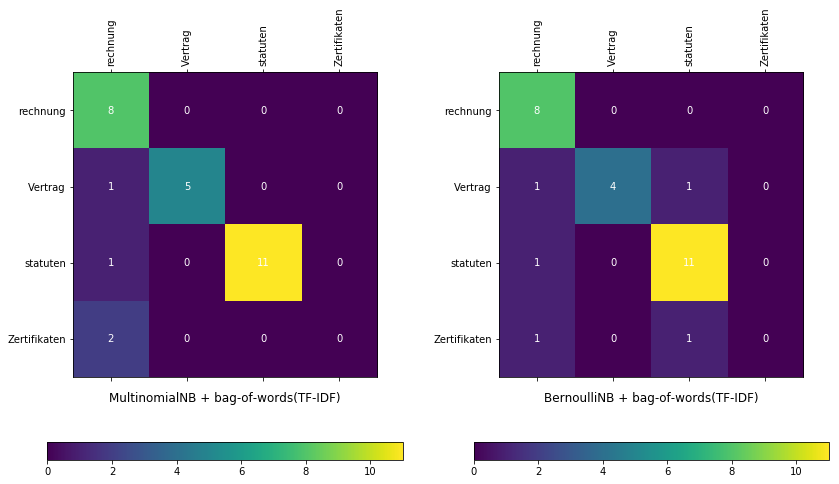

In [17]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(121)
cax = ax.matshow(cm_mnb_idf)
for i in range(cm_mnb_idf.shape[0]):
    for j in range(cm_mnb_idf.shape[1]):
        text = ax.text(j, i, cm_mnb_idf[i, j],
                       ha="center", va="center", color="w")
#p0 = ax.get_position().get_points().flatten()
plt.colorbar(cax,orientation='horizontal')

# Set up axes
ax.set_xticklabels([''] + label_name, rotation=90)
ax.set_yticklabels([''] + label_name)
ax.set_title("MultinomialNB + bag-of-words(TF-IDF)",y=-0.1)
# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# sphinx_gallery_thumbnail_number = 2
ax1 = fig.add_subplot(122)
cax1 = ax1.matshow(cm_bnb_idf)
for i in range(cm_bnb_idf.shape[0]):
    for j in range(cm_bnb_idf.shape[1]):
        text = ax1.text(j, i, cm_bnb_idf[i, j],
                       ha="center", va="center", color="w")
plt.colorbar(cax1,orientation='horizontal')

# Set up axes
ax1.set_xticklabels([''] + label_name, rotation=90)
ax1.set_yticklabels([''] + label_name)
ax1.set_title("BernoulliNB + bag-of-words(TF-IDF)",y=-0.1)
# Force label at every tick
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))
# sphinx_gallery_thumbnail_number = 2

plt.show()

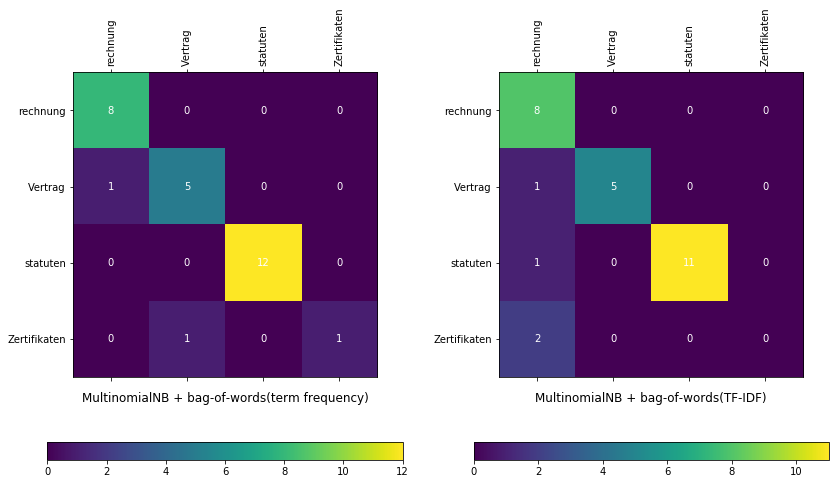

In [18]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(121)
cax = ax.matshow(cm_mnb)

for i in range(cm_mnb.shape[0]):
    for j in range(cm_mnb.shape[1]):
        text = ax.text(j, i, cm_mnb[i, j],
                       ha="center", va="center", color="w")
        
#p0 = ax.get_position().get_points().flatten()
plt.colorbar(cax,orientation='horizontal')

# Set up axes
ax.set_xticklabels([''] + label_name, rotation=90)
ax.set_yticklabels([''] + label_name)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_title("MultinomialNB + bag-of-words(term frequency)",y=-0.1)
# sphinx_gallery_thumbnail_number = 2
ax1 = fig.add_subplot(122)
cax1 = ax1.matshow(cm_mnb_idf)

for i in range(cm_mnb_idf.shape[0]):
    for j in range(cm_mnb_idf.shape[1]):
        text = ax1.text(j, i, cm_mnb_idf[i, j],
                       ha="center", va="center", color="w")
#p0 = ax.get_position().get_points().flatten()
plt.colorbar(cax1,orientation='horizontal')

# Set up axes
ax1.set_xticklabels([''] + label_name, rotation=90)
ax1.set_yticklabels([''] + label_name)
ax1.set_title("MultinomialNB + bag-of-words(TF-IDF)",y=-0.1)
# Force label at every tick
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))
# sphinx_gallery_thumbnail_number = 2
#plt.tight_layout()
plt.show()

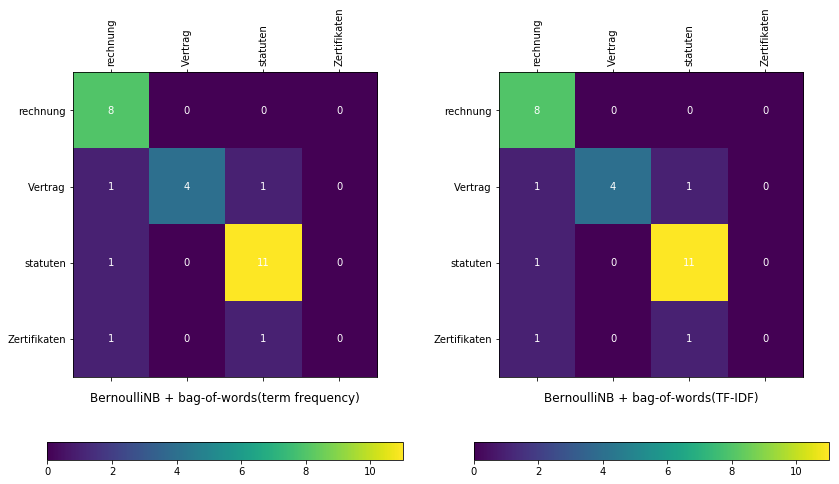

In [19]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(121)
cax = ax.matshow(cm_bnb)

for i in range(cm_bnb.shape[0]):
    for j in range(cm_bnb.shape[1]):
        text = ax.text(j, i, cm_bnb[i, j],
                       ha="center", va="center", color="w")
        
#p0 = ax.get_position().get_points().flatten()
plt.colorbar(cax,orientation='horizontal')

# Set up axes
ax.set_xticklabels([''] + label_name, rotation=90)
ax.set_yticklabels([''] + label_name)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_title("BernoulliNB + bag-of-words(term frequency)",y=-0.1)
# sphinx_gallery_thumbnail_number = 2
ax1 = fig.add_subplot(122)
cax1 = ax1.matshow(cm_bnb_idf)

for i in range(cm_bnb_idf.shape[0]):
    for j in range(cm_bnb_idf.shape[1]):
        text = ax1.text(j, i, cm_bnb_idf[i, j],
                       ha="center", va="center", color="w")
#p0 = ax.get_position().get_points().flatten()
plt.colorbar(cax1,orientation='horizontal')

# Set up axes
ax1.set_xticklabels([''] + label_name, rotation=90)
ax1.set_yticklabels([''] + label_name)
ax1.set_title("BernoulliNB + bag-of-words(TF-IDF)",y=-0.1)
# Force label at every tick
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))
# sphinx_gallery_thumbnail_number = 2
#plt.tight_layout()
plt.show()

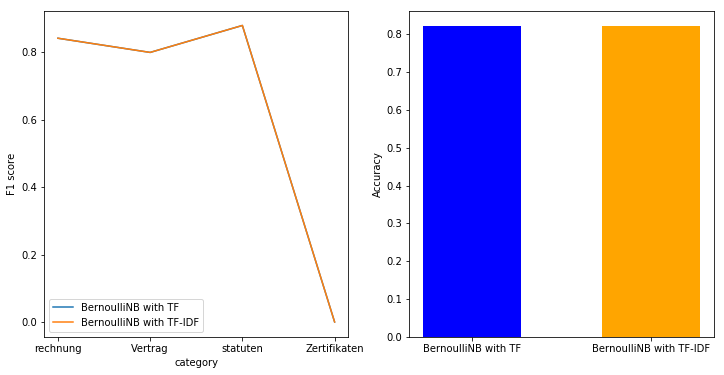

In [20]:

from matplotlib.pyplot import subplots, show

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(label_name,f1_bnb,label='BernoulliNB with TF')
plt.plot(label_name,f1_bnb_idf,label='BernoulliNB with TF-IDF')
plt.legend()
plt.xlabel("category")
plt.ylabel("F1 score")
plt.subplot(1,2,2)
plt.bar(["BernoulliNB with TF","BernoulliNB with TF-IDF"],[ac_bnb,ac_bnb_idf],color=['blue','orange'],width = 0.55)
plt.ylabel("Accuracy")
show()

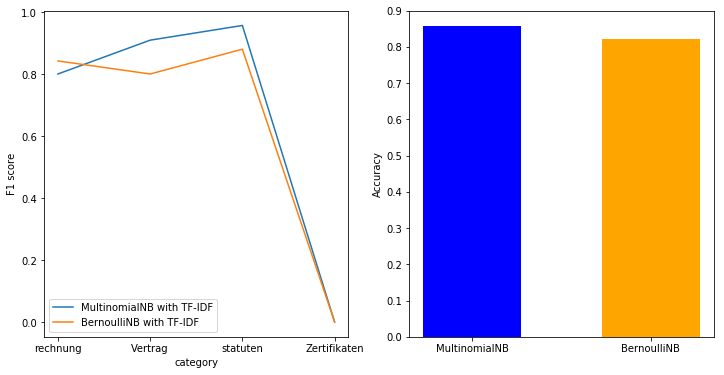

In [21]:

from matplotlib.pyplot import subplots, show

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(label_name,f1_mnb_idf,label='MultinomialNB with TF-IDF')
plt.plot(label_name,f1_bnb_idf,label='BernoulliNB with TF-IDF')
plt.legend()
plt.xlabel("category")
plt.ylabel("F1 score")
plt.subplot(1,2,2)
plt.bar(["MultinomialNB","BernoulliNB"],[ac_mnb_idf,ac_bnb_idf],color=['blue','orange'],width = 0.55)
plt.ylabel("Accuracy")
show()

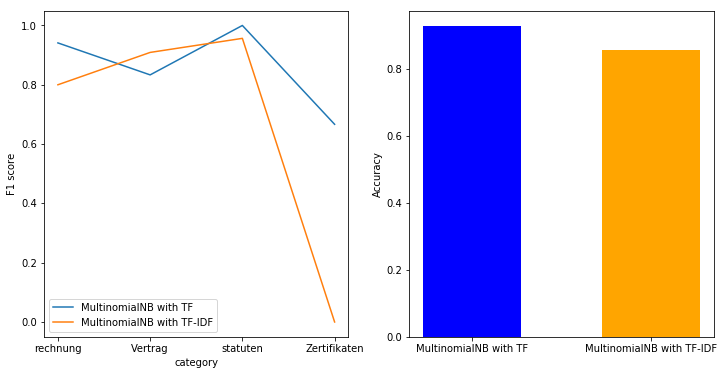

In [22]:

from matplotlib.pyplot import subplots, show

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(label_name,f1_mnb,label='MultinomialNB with TF')
plt.plot(label_name,f1_mnb_idf,label='MultinomialNB with TF-IDF')
plt.legend()
plt.xlabel("category")
plt.ylabel("F1 score")
plt.subplot(1,2,2)
plt.bar(["MultinomialNB with TF","MultinomialNB with TF-IDF"],[ac_mnb,ac_mnb_idf],color=['blue','orange'],width = 0.55)
plt.ylabel("Accuracy")
show()

In [23]:
# SVM

from sklearn import svm
classifier = svm.LinearSVC()
classifier.fit(tfidf_docs, train_y)
acc_svm_idf = classifier.score(tfidf_docs_test, test_y)
pre_svm_idf = classifier.predict(tfidf_docs_test)
cm_svm_idf = metrics.confusion_matrix(test_y,pre_svm_idf)
f1_svm_idf = f1_score(pre_svm_idf, test_y, average=None)
print(cm_svm_idf)
print("Accuracy tfidf:", acc_svm_idf)
print("F1 score tfidf:", f1_svm_idf)

classifier = svm.LinearSVC()
classifier.fit(tf_docs, train_y)
acc_svm = classifier.score(tf_docs_test, test_y)
pre_svm = classifier.predict(tf_docs_test)
cm_svm = metrics.confusion_matrix(test_y,pre_svm)
f1_svm = f1_score(pre_svm, test_y, average=None)
print(cm_svm)
print("Accuracy tf:", acc_svm)
print("F1 score tf:", f1_svm)

[[ 8  0  0  0]
 [ 1  5  0  0]
 [ 0  0 12  0]
 [ 0  0  0  2]]
Accuracy tfidf: 0.9642857142857143
F1 score tfidf: [0.94117647 0.90909091 1.         1.        ]
[[ 8  0  0  0]
 [ 1  5  0  0]
 [ 0  0 12  0]
 [ 0  0  0  2]]
Accuracy tf: 0.9642857142857143
F1 score tf: [0.94117647 0.90909091 1.         1.        ]


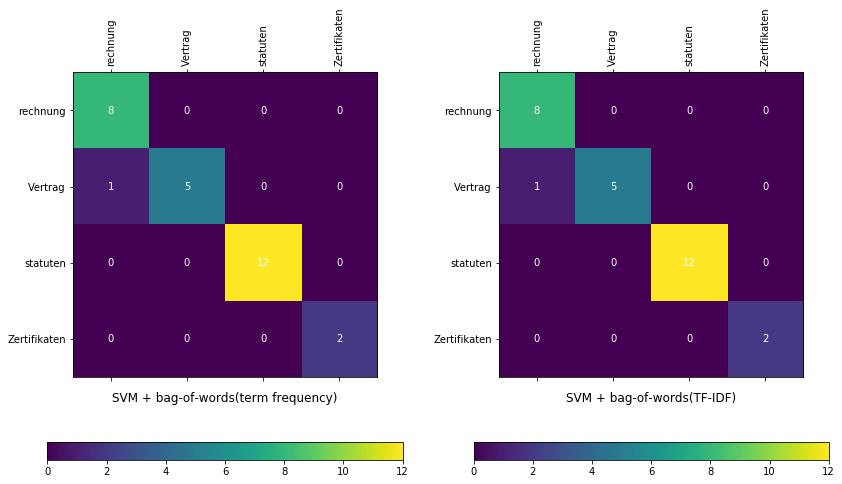

In [24]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(121)
cax = ax.matshow(cm_svm)
#p0 = ax.get_position().get_points().flatten()
plt.colorbar(cax,orientation='horizontal')
for i in range(cm_svm.shape[0]):
    for j in range(cm_svm.shape[1]):
        text = ax.text(j, i, cm_svm[i, j],
                       ha="center", va="center", color="w")
# Set up axes
ax.set_xticklabels([''] + label_name, rotation=90)
ax.set_yticklabels([''] + label_name)
ax.set_title("SVM + bag-of-words(term frequency)",y=-0.1)
# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# sphinx_gallery_thumbnail_number = 2
ax1 = fig.add_subplot(122)
cax1 = ax1.matshow(cm_svm_idf)
# p1=ax1.get_position().get_points().flatten()
# x_cbar = fig.add_axes([p0[0], 0, p1[2]-p0[0], 0.05])
plt.colorbar(cax1,orientation='horizontal')
for i in range(cm_svm_idf.shape[0]):
    for j in range(cm_svm_idf.shape[1]):
        text = ax1.text(j, i, cm_svm_idf[i, j],
                       ha="center", va="center", color="w")
# Set up axes
ax1.set_xticklabels([''] + label_name, rotation=90)
ax1.set_yticklabels([''] + label_name)
ax1.set_title("SVM + bag-of-words(TF-IDF)",y=-0.1)
# Force label at every tick
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))
# sphinx_gallery_thumbnail_number = 2

plt.show()

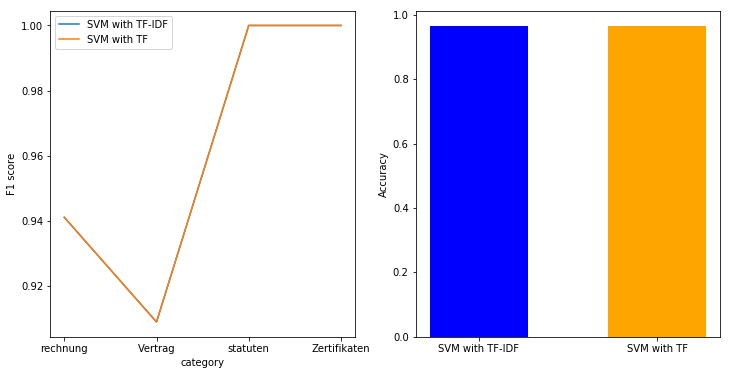

In [25]:
from matplotlib.pyplot import subplots, show

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(label_name,f1_svm_idf,label='SVM with TF-IDF')
plt.plot(label_name,f1_svm,label='SVM with TF')
plt.legend()
plt.xlabel("category")
plt.ylabel("F1 score")
plt.subplot(1,2,2)
plt.bar(["SVM with TF-IDF","SVM with TF"],[acc_svm_idf,acc_svm],color=['blue','orange'],width = 0.55)
plt.ylabel("Accuracy")
show()

In [26]:
# deep learning + TF
H1 = 64  # number of neurons
H2 = 100
E = 20  # number of epochs
B = 3  # batch size
D = tf_docs.shape[1]  # dimension of input sample
n_classes = 4
Y_train = np_utils.to_categorical(train_y, n_classes)
Y_test = np_utils.to_categorical(test_y, n_classes)
print(D)
model = Sequential()
model.add(Dense(H1,input_shape=(D,),activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(H2,activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(n_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

log = model.fit(tf_docs, Y_train, batch_size=B, epochs=E, verbose=1, validation_data=(tf_docs_test, Y_test))

8104
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                518720    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               6500      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 404       
Total params: 525,624
Trainable params: 525,624
Non-trainable params: 0
_________________________________________________________________
Train on 112 samples, validate on 28 samples
Epoch 1/20
112/112 [==============================] - 1s 8ms/step - loss: 0.8773 - acc: 0.7500 - val_loss: 0.8307 - val_acc: 0.8929
Epoch 2/20
112/112 [==============================] - 0s 3ms/step - loss: 0.2270 - acc: 0.9911 - val_loss: 0.7187 - val_acc: 0.9286
Epoch 3/20
112/112 [==============================] - 0s 3ms/step - loss: 0.1614 - acc

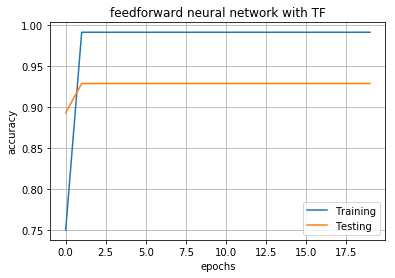

In [27]:
plt.plot(log.history['acc'], label='Training')
plt.plot(log.history['val_acc'], label='Testing')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("feedforward neural network with TF")
plt.legend()
plt.grid()
plt.show()

In [28]:
pred_nn = model.predict_classes(tf_docs_test, verbose=1)
cm_nn = metrics.confusion_matrix(test_y, pred_nn)
f1_nn = f1_score(pred_nn, test_y, average=None)
print(cm_nn)
print(f1_nn)

28/28 [==============================] - 0s 1ms/step
[[ 8  0  0  0]
 [ 1  5  0  0]
 [ 1  0 11  0]
 [ 0  0  0  2]]
[0.88888889 0.90909091 0.95652174 1.        ]


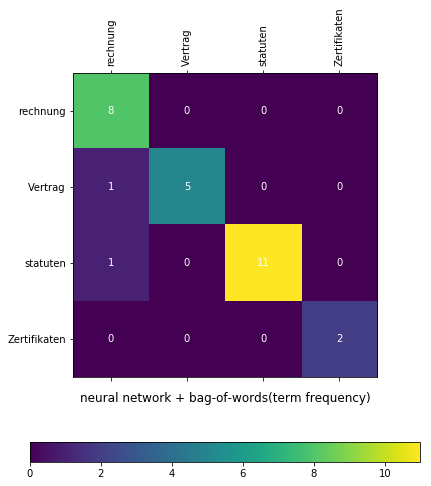

In [29]:
fig = plt.figure(figsize=(7, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(cm_nn)
#p0 = ax.get_position().get_points().flatten()
plt.colorbar(cax,orientation='horizontal')
for i in range(cm_nn.shape[0]):
    for j in range(cm_nn.shape[1]):
        text = ax.text(j, i, cm_nn[i, j],
                       ha="center", va="center", color="w")
# Set up axes
ax.set_xticklabels([''] + label_name, rotation=90)
ax.set_yticklabels([''] + label_name)
ax.set_title("neural network + bag-of-words(term frequency)",y=-0.1)
# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

In [30]:
H1 = 64  # number of neurons
H2 = 100
E = 20  # number of epochs
B = 3  # batch size
D = tf_docs.shape[1]  # dimension of input sample
n_classes = 4
Y_train = np_utils.to_categorical(train_y, n_classes)
Y_test = np_utils.to_categorical(test_y, n_classes)
print(D)
model = Sequential()
model.add(Dense(H1,input_shape=(D,),activation='relu'))

model.add(Dense(H2,activation='relu'))

model.add(Dense(n_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


log1 = model.fit(tfidf_docs, Y_train, batch_size=B, epochs=E, verbose=1, validation_data=(tfidf_docs_test, Y_test))

8104
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                518720    
_________________________________________________________________
dense_5 (Dense)              (None, 100)               6500      
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 404       
Total params: 525,624
Trainable params: 525,624
Non-trainable params: 0
_________________________________________________________________
Train on 112 samples, validate on 28 samples
Epoch 1/20
112/112 [==============================] - 1s 6ms/step - loss: 1.3225 - acc: 0.5179 - val_loss: 1.1144 - val_acc: 0.8571
Epoch 2/20
112/112 [==============================] - 0s 3ms/step - loss: 0.7681 - acc: 0.8661 - val_loss: 0.4186 - val_acc: 0.8929
Epoch 3/20
112/112 [==============================] - 0s 3ms/step - loss: 0.2154 - acc

In [31]:
pred_nn_idf = model.predict_classes(tfidf_docs_test, verbose=1)
cm_nn_idf = metrics.confusion_matrix(test_y, pred_nn_idf)
f1_nn_idf = f1_score(pred_nn_idf, test_y, average=None)
print(cm_nn_idf)
print(f1_nn_idf)


28/28 [==============================] - 0s 2ms/step
[[ 8  0  0  0]
 [ 1  5  0  0]
 [ 0  0 12  0]
 [ 0  0  0  2]]
[0.94117647 0.90909091 1.         1.        ]


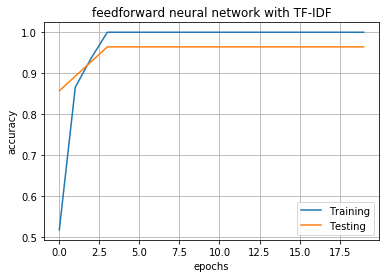

In [32]:
plt.plot(log1.history['acc'], label='Training')
plt.plot(log1.history['val_acc'], label='Testing')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("feedforward neural network with TF-IDF")
plt.legend()
plt.grid()
plt.show()

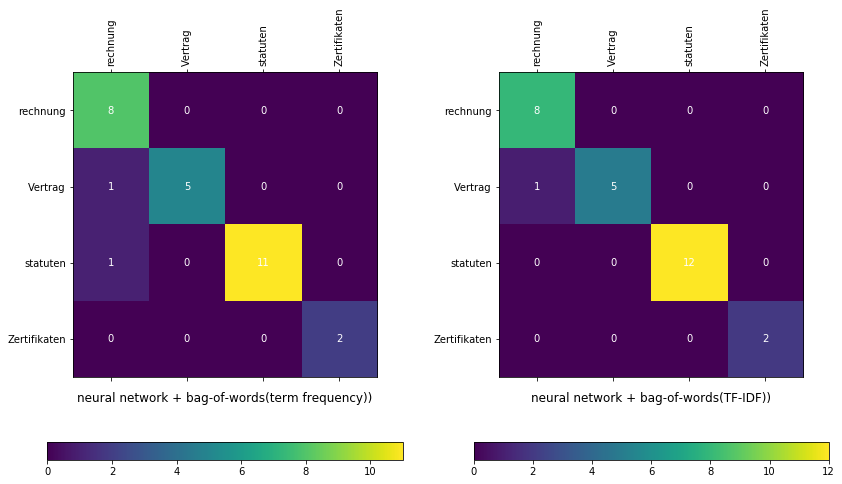

In [33]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(121)
cax = ax.matshow(cm_nn)
#p0 = ax.get_position().get_points().flatten()
plt.colorbar(cax,orientation='horizontal')
for i in range(cm_nn.shape[0]):
    for j in range(cm_nn.shape[1]):
        text = ax.text(j, i, cm_nn[i, j],
                       ha="center", va="center", color="w")
# Set up axes
ax.set_xticklabels([''] + label_name, rotation=90)
ax.set_yticklabels([''] + label_name)
ax.set_title("neural network + bag-of-words(term frequency))",y=-0.1)
# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# sphinx_gallery_thumbnail_number = 2
ax1 = fig.add_subplot(122)
cax1 = ax1.matshow(cm_nn_idf)
plt.colorbar(cax1,orientation='horizontal')
for i in range(cm_nn_idf.shape[0]):
    for j in range(cm_nn_idf.shape[1]):
        text = ax1.text(j, i, cm_nn_idf[i, j],
                       ha="center", va="center", color="w")
# Set up axes
ax1.set_xticklabels([''] + label_name, rotation=90)
ax1.set_yticklabels([''] + label_name)
ax1.set_title("neural network + bag-of-words(TF-IDF))",y=-0.1)
# Force label at every tick
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))
# sphinx_gallery_thumbnail_number = 2

plt.show()

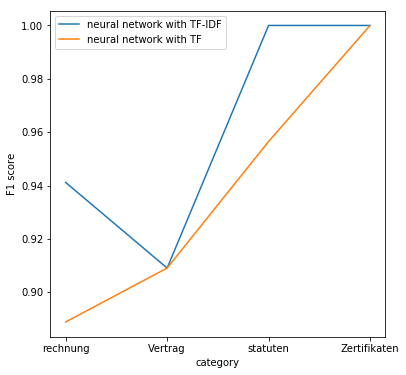

In [34]:
from matplotlib.pyplot import subplots, show

plt.figure(figsize=(6,6))
plt.subplot(1,1,1)
plt.plot(label_name,f1_nn_idf,label='neural network with TF-IDF')
plt.plot(label_name,f1_nn,label='neural network with TF')
plt.legend()
plt.xlabel("category")
plt.ylabel("F1 score")

show()

In [35]:
type(trainDF['doc'])


pandas.core.series.Series

In [36]:
import gensim
from gensim import corpora,models,similarities
from gensim.models import Word2Vec
corpus = [nltk.word_tokenize(doc,language='german') for doc in trainDF['doc']]
print(type(corpus))
len(corpus)

model = Word2Vec(
        corpus,
        size=150,
        window=5,
        min_count=1,
        workers=2)
print(model)
words = list(model.wv.vocab)
print(len(words))
model.train(corpus, total_examples=len(corpus), epochs=10)
model.save("word2vec.model")

<class 'list'>
Word2Vec(vocab=9753, size=150, alpha=0.025)
9753


In [37]:
print(len(corpus))
model = Word2Vec.load("word2vec.model")
w = "zertifikat"
model.wv.most_similar(positive = w)

140


[('grosst', 0.9981464743614197),
 ('erstfufiso/iec', 0.9975873827934265),
 ('sonderrufnumm', 0.9975323677062988),
 ('sozialversicherungsbeitrag', 0.9974828362464905),
 ('seinem/ihr', 0.9974537491798401),
 ('konzern', 0.9973393082618713),
 ('ergonom', 0.99721759557724),
 ('euepflicht', 0.9972127676010132),
 ('erwachsenenunterhalt', 0.9971447587013245),
 ('geschenk', 0.9970550537109375)]

In [38]:
def EmbedDoc(doc, word2vectors, word2index, tfidf_vector):
    tokens = TokenizeDoc(doc)
    doc2vec = np.zeros((5000, vec_len))
    
    bow = tfidf_vectorizer.transform([doc])
    print(bow.shape)

    for j in range(len(tokens)):
        if j >= 5000:
            break
        doc2vec[j] = word2vectors[tokens[j]]
        
    return doc2vec

In [39]:
vec_len = 150
feature_names = np.array(tfidf_vectorizer.get_feature_names())
vocab_size = len(feature_names)
print(vocab_size)

word2vectors = defaultdict()
word2vectors.default_factory = lambda : np.zeros(vec_len,)

word2index = defaultdict()
word2index.default_factory = lambda : -1

tfidf_vector = tfidf_vectorizer.fit_transform(trainDF['doc'])

for i, word in enumerate(feature_names):
    word2index[word] = i
    if word in model.wv.vocab:
        result = np.zeros(vec_len,)
        result = model[word]
        word2vectors[word]= result
    else:
        word2vectors[word]=np.zeros(vec_len,)

trainDF['doc_embed'] = trainDF.apply(lambda row: 
                               EmbedDoc(row['doc'], word2vectors, word2index, tfidf_vectorizer), axis=1)
new_emdd_docs,new_emdd_docs_test,new_train_y,new_test_y = model_selection.train_test_split(trainDF['doc_embed'], trainDF['label'],test_size=0.2)

print(new_emdd_docs,new_emdd_docs_test.shape)
print(new_emdd_docs[0])

8104


/Users/alleriali/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)
(1, 8698)


In [40]:
new_emdd_docs_3d = np.stack(new_emdd_docs.values)
print(new_emdd_docs_3d.shape)

(112, 5000, 150)


In [41]:
new_emdd_docs_test_3d = np.stack(new_emdd_docs_test.values)
print(new_emdd_docs_test_3d.shape)

(28, 5000, 150)


In [42]:
from keras.layers import Conv2D, MaxPooling2D,Flatten,Conv1D,GlobalMaxPooling1D,Embedding
from keras.utils import np_utils
# Conv + TF
H = 100  # number of neurons
E = 20  # number of epochs
B = 3  # batch size

n_classes = 4
Y_train = np_utils.to_categorical(new_train_y, n_classes)
Y_test = np_utils.to_categorical(new_test_y, n_classes)
model1 = Sequential()

model1.add(Conv1D(64,kernel_size=3,input_shape=(5000,150),padding='valid',activation='relu'))
model1.add(GlobalMaxPooling1D())
#model1.add(Conv1D(64,kernel_size=5,activation='relu'))
# model1.add(Dropout(0.25))
model1.add(Dense(H,activation='relu'))
model1.add(Dense(n_classes,activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

log = model1.fit(new_emdd_docs_3d, Y_train, batch_size=B, epochs=E, verbose=1, validation_data=(new_emdd_docs_test_3d, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 4998, 64)          28864     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6500      
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 404       
Total params: 35,768
Trainable params: 35,768
Non-trainable params: 0
_________________________________________________________________
Train on 112 samples, validate on 28 samples
Epoch 1/20
112/112 [==============================] - 6s 52ms/step - loss: 0.7875 - acc: 0.6964 - val_loss: 0.5629 - val_acc: 0.7857
Epoch 2/20
112/112 [==============================] - 4s 40ms/step - loss: 0.3599 - acc: 0.8

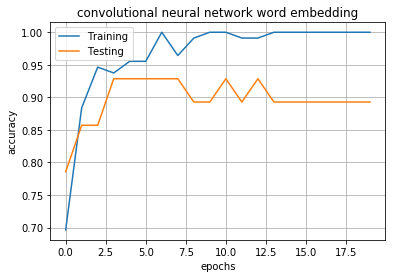

In [43]:
plt.plot(log.history['acc'], label='Training')
plt.plot(log.history['val_acc'], label='Testing')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("convolutional neural network word embedding")
plt.legend()
plt.grid()
plt.show()

In [44]:
pred_conv_em = model1.predict_classes(new_emdd_docs_test_3d, verbose=1)
cm_conv_em = metrics.confusion_matrix(new_test_y, pred_conv_em)
f1_conv_em = f1_score(pred_conv_em, new_test_y, average=None)
print(cm_conv_em)
print(f1_conv_em)

28/28 [==============================] - 1s 40ms/step
[[11  0  0  0]
 [ 0  6  0  0]
 [ 0  1  8  1]
 [ 0  1  0  0]]
[1.         0.85714286 0.88888889 0.        ]


(0.4, 1)

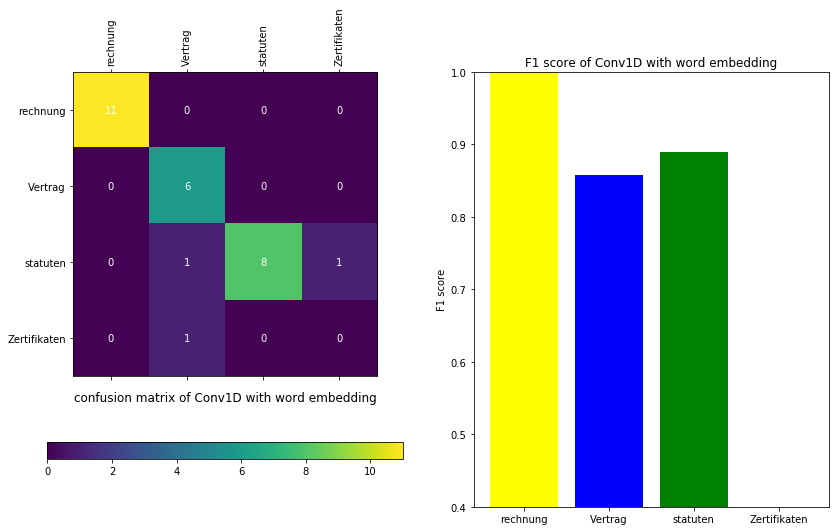

In [45]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(121)
cax = ax.matshow(cm_conv_em)

for i in range(cm_conv_em.shape[0]):
    for j in range(cm_conv_em.shape[1]):
        text = ax.text(j, i, cm_conv_em[i, j],
                       ha="center", va="center", color="w")
        
#p0 = ax.get_position().get_points().flatten()
plt.colorbar(cax,orientation='horizontal')

# Set up axes
ax.set_xticklabels([''] + label_name, rotation=90)
ax.set_yticklabels([''] + label_name)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_title("confusion matrix of Conv1D with word embedding",y=-0.1)

ax1 = fig.add_subplot(122)
ax1.bar(label_name,f1_conv_em,color=['yellow','blue','green','cyan'])
ax1.set_title("F1 score of Conv1D with word embedding")
ax1.set_ylabel("F1 score")
ax1.set_ylim(0.4,1)

In [47]:
from keras.layers import Conv2D, MaxPooling2D,Flatten,Conv1D,GlobalMaxPooling1D,Embedding
from keras.utils import np_utils
# Conv + TF
H = 100  # number of neurons
E = 20  # number of epochs
B = 3  # batch size

n_classes = 4
Y_train = np_utils.to_categorical(new_train_y, n_classes)
Y_test = np_utils.to_categorical(new_test_y, n_classes)
model1 = Sequential()

model1.add(Conv1D(64,kernel_size=5,input_shape=(5000,150),padding='valid',activation='relu'))
model1.add(GlobalMaxPooling1D())
model1.add(Dropout(0.25))
model1.add(Dense(H,activation='relu'))
model1.add(Dense(n_classes,activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()


print(Y_train.shape)

print(Y_test.shape)
log = model1.fit(new_emdd_docs_3d, Y_train, batch_size=B, epochs=E, verbose=1, validation_data=(new_emdd_docs_test_3d, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 4996, 64)          48064     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               6500      
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 404       
Total params: 54,968
Trainable params: 54,968
Non-trainable params: 0
_________________________________________________________________
(112, 4)
(28, 4)
Train on 112 samples, validate on 28 samples
Epoch 1/20
112/112 [==============================] - 8s 68ms/step - loss: 1

In [49]:
from keras.models import Model
from keras.layers import Input,concatenate

In [50]:
Y_train = np_utils.to_categorical(new_train_y, n_classes)
Y_test = np_utils.to_categorical(new_test_y, n_classes)
input_data = Input(shape=(5000,150))
conv0 = Conv1D(64,kernel_size=2,padding='valid',activation='relu')(input_data)
pool0 = GlobalMaxPooling1D()(conv0)
conv1 = Conv1D(64,kernel_size=3,padding='valid',activation='relu')(input_data)
pool1 = GlobalMaxPooling1D()(conv1)
conv2 = Conv1D(64,kernel_size=4,padding='valid',activation='relu')(input_data)
pool1 = GlobalMaxPooling1D()(conv2)
merge = concatenate([pool0,pool1,pool1])
dense1= Dense(H,activation='relu')(merge)
dropout1 = Dropout(0.4)(dense1)
output = Dense(n_classes,activation='softmax')(dropout1)
model_new = Model(inputs = input_data,outputs=output)
model_new.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_new.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5000, 150)    0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 4999, 64)     19264       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 4997, 64)     38464       input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling1d_4 (GlobalM (None, 64)           0           conv1d_4[0][0]                   
__________________________________________________________________________________________________
global_max

In [51]:
log_new = model_new.fit(new_emdd_docs_3d, Y_train, batch_size=B, epochs=E, verbose=1, validation_data=(new_emdd_docs_test_3d, Y_test))

Train on 112 samples, validate on 28 samples
Epoch 1/20
112/112 [==============================] - 12s 107ms/step - loss: 1.1145 - acc: 0.5714 - val_loss: 0.7756 - val_acc: 0.7500
Epoch 2/20
112/112 [==============================] - 7s 66ms/step - loss: 0.7031 - acc: 0.7679 - val_loss: 0.4061 - val_acc: 0.8929
Epoch 3/20
112/112 [==============================] - 7s 63ms/step - loss: 0.4321 - acc: 0.8393 - val_loss: 0.3760 - val_acc: 0.8571
Epoch 4/20
112/112 [==============================] - 8s 71ms/step - loss: 0.3376 - acc: 0.8750 - val_loss: 0.5512 - val_acc: 0.8571
Epoch 5/20
112/112 [==============================] - 10s 86ms/step - loss: 0.2759 - acc: 0.9286 - val_loss: 0.3880 - val_acc: 0.8571
Epoch 6/20
112/112 [==============================] - 7s 66ms/step - loss: 0.3114 - acc: 0.9018 - val_loss: 0.7482 - val_acc: 0.8214
Epoch 7/20
112/112 [==============================] - 8s 73ms/step - loss: 0.3214 - acc: 0.8929 - val_loss: 0.7168 - val_acc: 0.8214
Epoch 8/20
112/112 [=

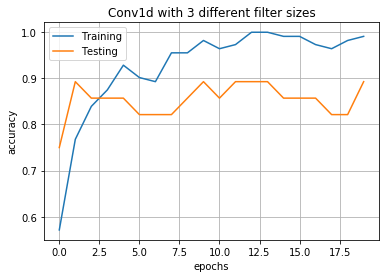

In [52]:
plt.plot(log_new.history['acc'], label='Training')
plt.plot(log_new.history['val_acc'], label='Testing')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Conv1d with 3 different filter sizes")
plt.legend()
plt.grid()
plt.show()

In [54]:
pred_conv3_em = model_new.predict(new_emdd_docs_test_3d, verbose=1)

pred_conv3_em = np.argmax(pred_conv3_em,axis=1)

cm_conv3_em = metrics.confusion_matrix(new_test_y, pred_conv3_em)
f1_conv3_em = f1_score(pred_conv3_em, new_test_y, average=None)
print(cm_conv3_em)
print(f1_conv3_em)

28/28 [==============================] - 2s 66ms/step
[[11  0  0  0]
 [ 0  6  0  0]
 [ 0  1  8  1]
 [ 0  1  0  0]]
[1.         0.85714286 0.88888889 0.        ]


(0.4, 1)

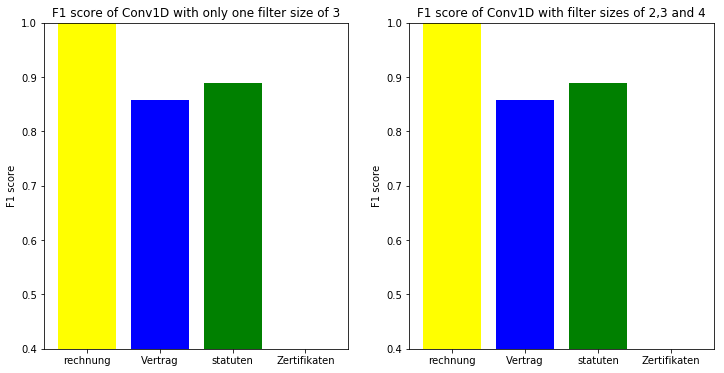

In [55]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.bar(label_name,f1_conv_em,color=['yellow','blue','green','cyan'],label="with one filter size of 3 ")
ax.set_title("F1 score of Conv1D with only one filter size of 3")
ax.set_ylabel("F1 score")
ax.set_ylim(0.4,1)
ax1 = fig.add_subplot(122)
ax1.bar(label_name,f1_conv3_em,color=['yellow','blue','green','cyan'])
ax1.set_title("F1 score of Conv1D with filter sizes of 2,3 and 4")
ax1.set_ylabel("F1 score")
ax1.set_ylim(0.4,1)

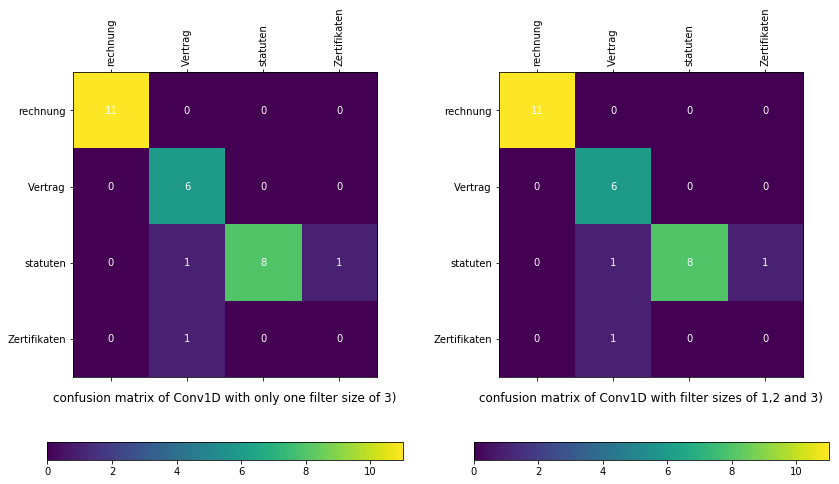

In [56]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(121)
cax = ax.matshow(cm_conv_em)
#p0 = ax.get_position().get_points().flatten()
plt.colorbar(cax,orientation='horizontal')
for i in range(cm_conv_em.shape[0]):
    for j in range(cm_conv_em.shape[1]):
        text = ax.text(j, i, cm_conv_em[i, j],
                       ha="center", va="center", color="w")
# Set up axes
ax.set_xticklabels([''] + label_name, rotation=90)
ax.set_yticklabels([''] + label_name)
ax.set_title("confusion matrix of Conv1D with only one filter size of 3)",y=-0.1)
# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# sphinx_gallery_thumbnail_number = 2
ax1 = fig.add_subplot(122)
cax1 = ax1.matshow(cm_conv3_em)
plt.colorbar(cax1,orientation='horizontal')
for i in range(cm_conv3_em.shape[0]):
    for j in range(cm_conv3_em.shape[1]):
        text = ax1.text(j, i, cm_conv3_em[i, j],
                       ha="center", va="center", color="w")
# Set up axes
ax1.set_xticklabels([''] + label_name, rotation=90)
ax1.set_yticklabels([''] + label_name)
ax1.set_title("confusion matrix of Conv1D with filter sizes of 1,2 and 3)",y=-0.1)
# Force label at every tick
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))
# sphinx_gallery_thumbnail_number = 2

plt.show()

(0.4, 1)

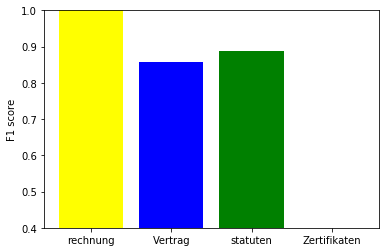

In [57]:
plt.bar(label_name,f1_conv_em,color=['yellow','blue','green','cyan'],label="with one filter size of 3 ")
plt.bar(label_name,f1_conv3_em,color=['yellow','blue','green','cyan'],label="with 3 filter sizes")
plt.ylabel("F1 score")
plt.ylim(0.4,1)

(0.4, 1)

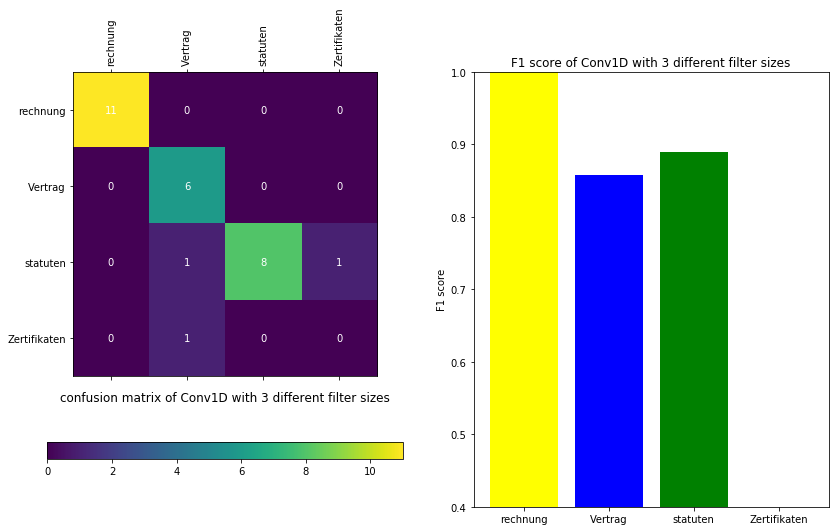

In [58]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(121)
cax = ax.matshow(cm_conv3_em)

for i in range(cm_conv3_em.shape[0]):
    for j in range(cm_conv3_em.shape[1]):
        text = ax.text(j, i, cm_conv3_em[i, j],
                       ha="center", va="center", color="w")
        
#p0 = ax.get_position().get_points().flatten()
plt.colorbar(cax,orientation='horizontal')

# Set up axes
ax.set_xticklabels([''] + label_name, rotation=90)
ax.set_yticklabels([''] + label_name)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_title("confusion matrix of Conv1D with 3 different filter sizes",y=-0.1)

ax1 = fig.add_subplot(122)
ax1.bar(label_name,f1_conv3_em,color=['yellow','blue','green','cyan'])
ax1.set_title("F1 score of Conv1D with 3 different filter sizes")
ax1.set_ylabel("F1 score")
ax1.set_ylim(0.4,1)

NameError: name 'cm_lstm_idf' is not defined

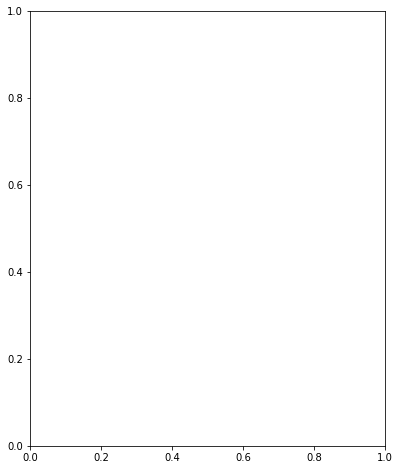

In [59]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(121)
cax = ax.matshow(cm_lstm_idf)

for i in range(cm_lstm_idf.shape[0]):
    for j in range(cm_lstm_idf.shape[1]):
        text = ax.text(j, i, cm_lstm_idf[i, j],
                       ha="center", va="center", color="w")
        
#p0 = ax.get_position().get_points().flatten()
plt.colorbar(cax,orientation='horizontal')

# Set up axes
ax.set_xticklabels([''] + label_name, rotation=90)
ax.set_yticklabels([''] + label_name)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_title("confusion matrix of LSTM with Word2Vec embedding",y=-0.1)

ax1 = fig.add_subplot(122)
ax1.bar(label_name,f1_lstm_idf,color=['yellow','blue','green','red'])
ax1.set_title("F1 score of LSTM with Word2Vec embedding")
ax1.set_ylabel("F1 score")

In [ ]:
cm_conv_idf=np.array([[1, 6 ,1 ,0],
 [2 ,3 ,2, 0],
 [1 ,6 ,2, 0],
 [0 ,3 , 1, 0]])

f1_conv_idf = [0.16666667, 0.24 , 0.26666667, 0     ]                

In [ ]:
model2 = Sequential()

model2.add(LSTM(units = 32, return_sequences = False,input_shape=(5000,150),kernel_regularizer=l2(0.005)))

model2.add(Dropout(0.3))
#model2.add(LSTM(H,kernel_regularizer=l2(0.005)))
#model.add(SimpleRNN(H,return_sequences=False,kernel_regularizer=l2(0.005)))
#model2.add(Dropout(0.3))
model2.add(Dense(n_classes,activation='softmax',activity_regularizer=l2(0.005)))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

log2 = model2.fit(new_emdd_docs_3d, Y_train, batch_size=B, epochs=20, verbose=1, validation_data=(new_emdd_docs_test_3d, Y_test))

In [ ]:
plt.plot(log2.history['acc'], label='Training')
plt.plot(log2.history['val_acc'], label='Testing')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("LSTM with word embedding")
plt.legend()
plt.grid()
plt.show()

In [ ]:
pred_lstm_em = model1.predict_classes(new_emdd_docs_test_3d, verbose=1)
print(pred_lstm_em)
print(new_test_y)
cm_lstm_em = metrics.confusion_matrix(new_test_y, pred_lstm_em)
f1_lstm_em = f1_score(pred_lstm_em, new_test_y, average=None)
print(cm_lstm_em)
print(f1_lstm_em)

In [ ]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(121)
cax = ax.matshow(cm_lstm_em)

for i in range(cm_lstm_em.shape[0]):
    for j in range(cm_lstm_em.shape[1]):
        text = ax.text(j, i, cm_lstm_em[i, j],
                       ha="center", va="center", color="w")
        
#p0 = ax.get_position().get_points().flatten()
plt.colorbar(cax,orientation='horizontal')

# Set up axes
ax.set_xticklabels([''] + label_name, rotation=90)
ax.set_yticklabels([''] + label_name)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_title("confusion matrix of LSTM with word embedding",y=-0.1)

ax1 = fig.add_subplot(122)
ax1.bar(label_name,f1_lstm_em,color=['yellow','blue','green','cyan'])
ax1.set_title("F1 score of LSTM with word embedding")
ax1.set_ylabel("F1 score")
ax1.set_ylim(0,1)

In [60]:
from sklearn.model_selection import cross_val_score

# MNB + TF cross validation
tf_corpus = count_vectorizer.fit_transform(trainDF['doc']) # sparse matrix

tfidf_corpus = tfidf_vectorizer.fit_transform(trainDF['doc'])

label_corpus = trainDF['label']

mnb_tf = cross_val_score(MultinomialNB(),tf_corpus,label_corpus,cv=10)
mnb_tf_mean = np.mean(mnb_tf)
print(mnb_tf_mean,np.std(mnb_tf))

0.9654166666666667 0.034962777826330296


In [61]:
mnb_tfidf = cross_val_score(MultinomialNB(),tfidf_corpus,label_corpus,cv=10)
mnb_tfidf_mean = np.mean(mnb_tfidf)
print(mnb_tfidf_mean,np.std(mnb_tfidf))

0.8526968864468865 0.050360715849240976


In [62]:
# SVM + TFIDF cross validation
svm_tfidf = cross_val_score(svm.LinearSVC(),tfidf_corpus,label_corpus,cv=10)
svm_tfidf_mean = np.mean(svm_tfidf)
print(svm_tfidf_mean,np.std(svm_tfidf))

0.9293910256410257 0.056735667251979004


In [72]:
# SVM + TF cross validation
svm_tf = cross_val_score(svm.LinearSVC(),tf_corpus,label_corpus,cv=10)
print(svm_tf)
svm_tf_mean = np.mean(svm_tf)
print(svm_tf_mean,np.std(svm_tf))

[1.         0.86666667 0.93333333 1.         1.         1.
 0.92307692 1.         1.         0.91666667]
0.963974358974359 0.04701633579607919


In [64]:
H1 = 64  # number of neurons
H2 = 100
E = 20  # number of epochs
B = 3  # batch size
D = tfidf_corpus.shape[1]  # dimension of input sample
n_classes = 4

model_cv = Sequential()
model_cv.add(Dense(H1,input_shape=(D,),activation='relu'))
model_cv.add(Dropout(0.4))
model_cv.add(Dense(H2,activation='relu'))
model_cv.add(Dropout(0.4))
model_cv.add(Dense(n_classes,activation='softmax'))
model_cv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                556736    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               6500      
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 404       
Total params: 563,640
Trainable params: 563,640
Non-trainable params: 0
_________________________________________________________________


In [65]:
#nerual network cross validation
label_corpus_nn = np_utils.to_categorical(label_corpus, n_classes)
cross_val_nn = 0
for i in range(10):
    train_xn, test_xn, train_yn, test_yn = model_selection.train_test_split(tfidf_corpus, trainDF['label'],test_size=0.1,shuffle=True,random_state=i)

    Yn_train = np_utils.to_categorical(train_yn, n_classes)
    Yn_test = np_utils.to_categorical(test_yn, n_classes)

    model_cv.fit(train_xn, Yn_train, batch_size=B, epochs=E, verbose=0)  
    score_cv=model_cv.evaluate(test_xn,Yn_test,verbose=0)
    print(score_cv)
    cross_val_nn +=score_cv[1]
cross_val_nn_mean = cross_val_nn/10
print(cross_val_nn_mean)


[0.02903776429593563, 1.0]
[3.2995631045196205e-06, 1.0]
[2.2124691895442083e-05, 1.0]
[1.5369522543551284e-06, 1.0]
[3.576281244477286e-07, 1.0]
[1.9499425434332807e-06, 1.0]
[1.2772423474416428e-07, 1.0]
[1.2346676214747276e-07, 1.0]
[4.2574782810334e-07, 1.0]
[4.853530981563381e-07, 1.0]
1.0


In [66]:
input_data = Input(shape=(5000,150))
conv0 = Conv1D(64,kernel_size=2,padding='valid',activation='relu')(input_data)
pool0 = GlobalMaxPooling1D()(conv0)
conv1 = Conv1D(64,kernel_size=3,padding='valid',activation='relu')(input_data)
pool1 = GlobalMaxPooling1D()(conv1)
conv2 = Conv1D(64,kernel_size=4,padding='valid',activation='relu')(input_data)
pool1 = GlobalMaxPooling1D()(conv2)
merge = concatenate([pool0,pool1,pool1])
dense1= Dense(H,activation='relu')(merge)
dropout1 = Dropout(0.4)(dense1)
output = Dense(n_classes,activation='softmax')(dropout1)
model_new = Model(inputs = input_data,outputs=output)
model_new.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_new.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 5000, 150)    0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 4999, 64)     19264       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 4997, 64)     38464       input_2[0][0]                    
__________________________________________________________________________________________________
global_max_pooling1d_7 (GlobalM (None, 64)           0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
global_max

In [69]:
cross_val_conv = 0
for i in range(10):
    new_emdd_docs_cv,new_emdd_docs_test_cv,new_train_y_cv,new_test_y_cv = model_selection.train_test_split(trainDF['doc_embed'], trainDF['label'],test_size=0.1,shuffle=True,random_state=i)
    new_emdd_docs_3d_cv = np.stack(new_emdd_docs_cv.values)
    new_emdd_docs_test_3d_cv = np.stack(new_emdd_docs_test_cv.values)
    Y_train_cv = np_utils.to_categorical(new_train_y_cv, n_classes)
    Y_test_cv = np_utils.to_categorical(new_test_y_cv, n_classes)
    model_new.fit(new_emdd_docs_3d_cv,Y_train_cv,batch_size=B, epochs=E, verbose=0)
    score_cv_conv=model_new.evaluate(new_emdd_docs_test_3d_cv,Y_test_cv,verbose=0)[1]
    print(score_cv_conv)
    cross_val_conv+=score_cv_conv
cross_val_conv_mean = cross_val_conv/10
print(cross_val_conv_mean,np.std(cross_val_conv_mean))
    


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0 0.0


<Figure size 1152x720 with 0 Axes>

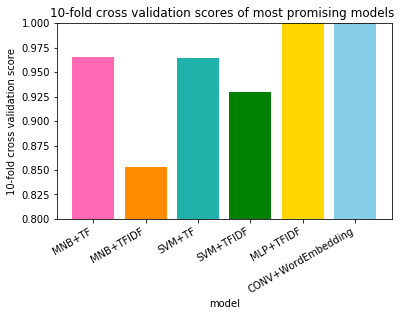

<Figure size 1152x720 with 0 Axes>

In [71]:
model_name = ["MNB+TF","MNB+TFIDF","SVM+TF","SVM+TFIDF","MLP+TFIDF","CONV+WordEmbedding"]
cv_score=[mnb_tf_mean,mnb_tfidf_mean,svm_tf_mean,svm_tfidf_mean,cross_val_nn_mean,cross_val_conv_mean]
plt.bar(model_name,cv_score,color=["hotpink","darkorange","lightseagreen","green","gold","skyblue"])
plt.title("10-fold cross validation scores of most promising models ")
plt.xlabel("model")
plt.ylim((0.8, 1)) 
plt.gcf().autofmt_xdate()
plt.ylabel("10-fold cross validation score")
plt.figure(figsize=(16,10))

In [73]:
cv_std = [np.std(mnb_tf),np.std(mnb_tfidf),np.std(svm_tfidf),np.std(svm_tf),0,0]
